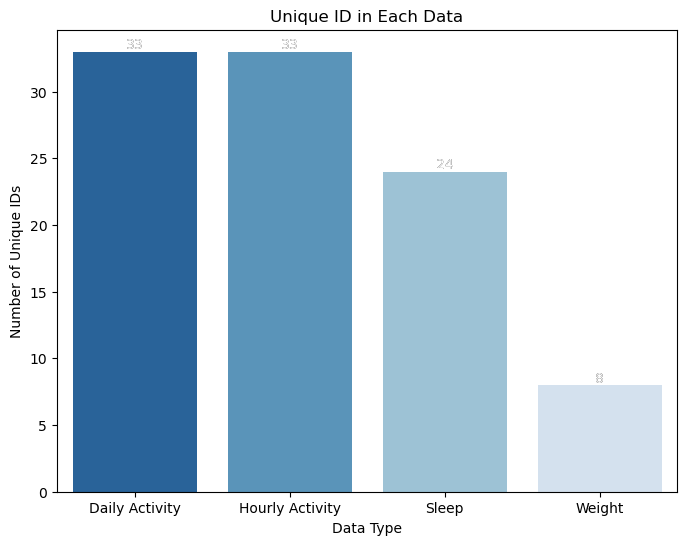

In [5]:
#PREPARE
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm


df_daily_activity = pd.read_csv(r'C:\Users\Rayyan Tech\Desktop\Capstone 2\Fitabase Data 4.12.16-5.12.16\dailyActivity_merged.csv')
df_daily_activity["ActivityDate"] = pd.to_datetime(df_daily_activity["ActivityDate"], format="%m/%d/%Y") # convert ActivityDate column to datetime

df_hourly_calories = pd.read_csv(r'C:\Users\Rayyan Tech\Desktop\Capstone 2\Fitabase Data 4.12.16-5.12.16\hourlyCalories_merged.csv')
df_hourly_calories["ActivityHour"] = pd.to_datetime(df_hourly_calories["ActivityHour"])

df_hourly_intensities = pd.read_csv(r'C:\Users\Rayyan Tech\Desktop\Capstone 2\Fitabase Data 4.12.16-5.12.16\hourlyIntensities_merged.csv')
df_hourly_intensities['ActivityHour'] = pd.to_datetime(df_hourly_intensities['ActivityHour'])

df_hourly_steps = pd.read_csv(r'C:\Users\Rayyan Tech\Desktop\Capstone 2\Fitabase Data 4.12.16-5.12.16\hourlySteps_merged.csv')
df_hourly_steps['ActivityHour'] = pd.to_datetime(df_hourly_steps['ActivityHour'])

df_sleepDay = pd.read_csv(r'C:\Users\Rayyan Tech\Desktop\Capstone 2\Fitabase Data 4.12.16-5.12.16\sleepDay_merged.csv')
df_sleepDay['SleepDay'] = pd.to_datetime(df_sleepDay['SleepDay'])

df_weight = pd.read_csv(r'C:\Users\Rayyan Tech\Desktop\Capstone 2\Fitabase Data 4.12.16-5.12.16\weightLogInfo_merged.csv')
df_weight['Date'] = pd.to_datetime(df_weight['Date'])

#PROCESS
# 1) df_daily_activity == df_daily
df_daily_activity.isnull().sum() #looking for nulls and duplicates in df_daily_activity
df_daily_activity.duplicated().sum()
#Result: No nulls or duplicates in df_daily_activity.
df_daily = df_daily_activity # rename dataframe
df_daily['weekday'] = df_daily['ActivityDate'].dt.strftime("%A") # create new column - weekday 
# Create new column named total_active_minutes:
df_daily['total_active_min'] = df_daily['VeryActiveMinutes']+ df_daily['FairlyActiveMinutes'] + df_daily['LightlyActiveMinutes']
# Rename to better visualize:
df_daily.rename(columns={'Id':'id', 'ActivityDate':'date', 'TotalSteps':'total_steps', 
                          'TotalDistance':'total_dist', 'TrackerDistance':'tracker_dist',
                         'LoggedActivitiesDistance':'logged_activity_dist', 
                          'VeryActiveDistance':'very_active_dist',
                         'ModeratelyActiveDistance':'moderate_active_dist', 
                          'LightActiveDistance':'light_active_dist', 
                          'SedentaryActiveDistance':'sedentary_active_dist', 
                          'VeryActiveMinutes':'very_active_min', 'FairlyActiveMinutes':'fairly_active_min',
                         'LightlyActiveMinutes':'light_active_min', 'SedentaryMinutes':'sedentary_min', 
                         'Calories':'calories'}, inplace=True)
df_daily.to_csv('df_daily.csv')


# 2) df_hourly_calories
df_hourly_calories.isnull().sum()
df_hourly_calories.duplicated().sum()
#Result: No nulls or duplicated in df_hourly_calories.

# 3) df_hourly_intensities
df_hourly_intensities.isnull().sum()
df_hourly_intensities.duplicated().sum()
#Result: No nulls or duplicates in df_hourly_intensities.

# 4) df_hourly_steps
df_hourly_steps.isnull().sum()
df_hourly_steps.duplicated().sum()
#Result: No nulls or duplicates in df_hourly_steps.

#Merge df_hourly_calories, df_hourly_intensities and df_hourly_steps
# To avoid process issues, merge 2 dataframes first:
df_hourly = pd.merge(df_hourly_calories, df_hourly_intensities, on=['Id', 'ActivityHour']) 
df_hourly = pd.merge(df_hourly, df_hourly_steps, on=['Id', 'ActivityHour'])
df_hourly['weekday'] = df_hourly['ActivityHour'].dt.strftime("%A") #creating weekday column
# Rename columns:
df_hourly = df_hourly.rename(columns={'Id':'id', 'ActivityHour':'activity_hour', 'Calories':'calories', 
                                      'StepTotal':'step_total', 'TotalIntensity':'total_intensity',
                                     'AverageIntensity':'average_intensity'})
df_hourly.to_csv('df_hourly.csv')

# Create XAxisLabel and DistinctN lists
XAxisLabel = ["Daily Activity", "Hourly Activity", "Sleep", "Weight"]
DistinctN = [df_daily['id'].nunique(), df_hourly['id'].nunique(), df_sleepDay['Id'].nunique(), df_weight['Id'].nunique()]

# Create UniqueId dataframe
UniqueId = pd.DataFrame({'XAxisLabel': XAxisLabel, 'DistinctN': DistinctN})

# Create bar plot using seaborn library
plt.figure(figsize=(8,6))
ax = sns.barplot(x='XAxisLabel', y='DistinctN', data=UniqueId, palette='Blues_r')

# Add value labels to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

# Add title and labels to the plot
plt.title("Unique ID in Each Data")
plt.xlabel("Data Type")
plt.ylabel("Number of Unique IDs")

# Add text labels to the bars
for i, v in enumerate(DistinctN):
    plt.text(i, v, str(v), color='white', ha='center', va='bottom')

plt.show()

In [11]:
#ANALYSE
df_daily.describe()
df_hourly.describe()

#Relationship between calories burned and the total steps walked in a day
figure = px.scatter(data_frame = df_daily, x="calories",
                    y="total_steps", size="very_active_min", 
                    trendline="ols", 
                    title="Relationship between Calories & Total Steps")
figure.show()
#Result: Linear relationship found

#Average total number of active minutes in a day
label = ["Very Active Minutes", "Fairly Active Minutes", 
         "Lightly Active Minutes", "Inactive Minutes"]
counts = df_daily[["very_active_min", "fairly_active_min", 
               "light_active_min", "sedentary_min"]].mean()
colors = ['lightyellow','lightblue', "lightpink", "lightgrey"]

fig = go.Figure(data=[go.Pie(labels=label, values=counts)])
fig.update_layout(title_text='Total Active Minutes')
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=15,
                  marker=dict(colors=colors))
fig.show()

#Number of inactive minutes on each day of the week
day = df_daily["weekday"].value_counts()
label = day.index
counts = df_daily["sedentary_min"]
colors = ["lightbrown","lightyellow", "lightgrey", "lightskyblue", "lightlilac", "lightcyan", "lightorange"]

fig = go.Figure(data=[go.Pie(labels=label, values=counts)])
fig.update_layout(title_text='Inactive Minutes Daily')
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=15,
                                     marker=dict(colors=colors))
fig.show()

#Active Vs. Sedentary 
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df_daily["weekday"],
    y=df_daily["total_active_min"],
    name='Active Minutes',
    marker_color='purple'
))
fig.add_trace(go.Bar(
    x=df_daily["weekday"],
    y=df_daily["sedentary_min"],
    name='Sedentary Minutes',
    marker_color='green'
))
fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text='Active Vs. Sedentary Time Daily')
fig.show()

#BAR GRAPH TRY
# # Number of inactive minutes on each day of the week
# day = df_daily["weekday"].value_counts()
# label = day.index
# counts = df_daily["sedentary_min"]
# colors = ["lightbrown","lightyellow", "lightgrey", "lightskyblue", "lightlilac", "lightcyan", "lightorange"]

# # Plot the bar graph
# plt.bar(label, counts, color=colors)
# plt.title("Inactive Minutes Daily")
# plt.xlabel("Day of the week")
# plt.ylabel("Number of inactive minutes")
# plt.show()

#Number of calories burned per weekday
calories = df_daily["weekday"].value_counts()
label = calories.index
counts = df_daily["calories"]
colors = ['aliceblue','bisque', "cadetblue", "mauve", "lightbrown", "lightpink", "lightgrey"]

fig = go.Figure(data=[go.Pie(labels=label, values=counts)])
fig.update_layout(title_text='Calories Burned Daily')
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=15,
                  marker=dict(colors=colors))
fig.show()

TESTING 1st HYPOTHESIS: H. = THERE IS NO SIGNIFICANT RELATIONSHIP BETWEEN HOW MUCH TIME A PERSON SPENDS BEING ACTIVE AND THE NUMBER OF CALORIES THEY BURN.


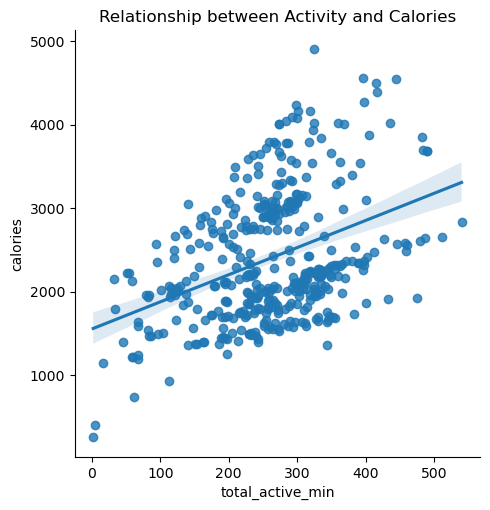

Correlation coefficient between TotalActiveTime and Calories: 0.3941880254498795
Calculated t-value: 8.695503562165063
Critical t-value: 1.9657526798608886
Null Hypothesis is rejected. Alternate Hypothesis is accepted, i.e. there is a positive relationship between the TotalActiveTime and Calories burnt.


In [34]:
#Merging the activity and sleep dataset

# Merge SleepDay and DailyActivity dataframes using 'Id' and 'Date' columns as the key
df_sleepDay.rename(columns={'Id':'id', 'SleepDay':'date', 'TotalSleepRecords':'total_sleep_records', 
                          'TotalMinutesAsleep':'total_minutes_asleep', 'TotalTimeInBed':'total_time_in_bed'}, inplace=True)
df_sleep_and_activity = pd.merge(df_sleepDay, df_daily, on=['id', 'date'])
df_sleep_and_activity.to_csv('df_sleep_and_activity.csv')


print('TESTING 1st HYPOTHESIS: H. = THERE IS NO SIGNIFICANT RELATIONSHIP BETWEEN HOW MUCH TIME A PERSON SPENDS BEING ACTIVE AND THE NUMBER OF CALORIES THEY BURN.')

# The null hypothesis for this right-tailed t-test states that there is no significant relationship 
# between how much time a person spends being active and the number of calories they burn. 
# The alternative hypothesis, on the other hand, states that there is a positive relationship between the two variables, 
# meaning that as the amount of time a person spends being active increases, so does the number of calories they burn.

# Plot TotalSteps vs Calories with a linear regression line
#a1 = sns.lmplot(data=df_sleep_and_activity, x='total_steps', y='calories')

# Plot TotalActiveTime vs Calories with a linear regression line
a2 = sns.lmplot(data=df_sleep_and_activity, x='total_active_min', y='calories')
plt.title('Relationship between Activity and Calories')
plt.show()

# Calculate the correlation coefficient between TotalActiveTime and Calories
corr = df_sleep_and_activity['total_active_min'].corr(df_sleep_and_activity['calories'])
print('Correlation coefficient between TotalActiveTime and Calories:', corr)

# Calculate the correlation coefficient between TotalActiveTime and Calories in df_daily dataframe
#corr_daily = df_sleep_and_activity['total_active_min'].corr(df_sleep_and_activity['calories'])
#print('Correlation coefficient between TotalActiveTime and Calories in DailyActivity:', corr_daily)

# Calculate the correlation coefficient
r, _ = stats.pearsonr(df_sleep_and_activity['total_active_min'], df_sleep_and_activity['calories'])

# Calculate the degrees of freedom
n = len(df_sleep_and_activity)
df = n - 2

# Calculate the t-statistic
t = r * np.sqrt(df / (1 - r**2))
print('Calculated t-value:', t)

# Set the level of significance
alpha = 0.05

# The t-critical value is the cutoff between retaining or rejecting the null hypothesis. 
# Whenever the t-statistic is farther from 0 than the t-critical value, the null hypothesis is rejected; otherwise, the null hypothesis is retained.
# Determine the critical t-value
critical_t = stats.t.ppf(1 - alpha/2, df)
print('Critical t-value:', critical_t)

# Reject the null hypothesis if the sample’s t value is greater than the critical value of t.
# Compare the calculated t-statistic to the critical t-value
if np.abs(t) > critical_t:
    print(f"Null Hypothesis is rejected. Alternate Hypothesis is accepted, i.e. there is a positive relationship between the TotalActiveTime and Calories burnt.")
else:
    print(f"Null Hypothesis is accepted. Alternate Hypothesis is rejected, i.e. there is no significant relationship between the TotalActiveTime and Calories burnt.")


TESTING 2nd HYPOTHESIS: H. = THERE IS NO SIGNIFICANT RELATIONSHIP BETWEEN HOW MUCH TIME A PERSON SPENDS BEING ACTIVE AND THE LENGTH OF SLEEP.


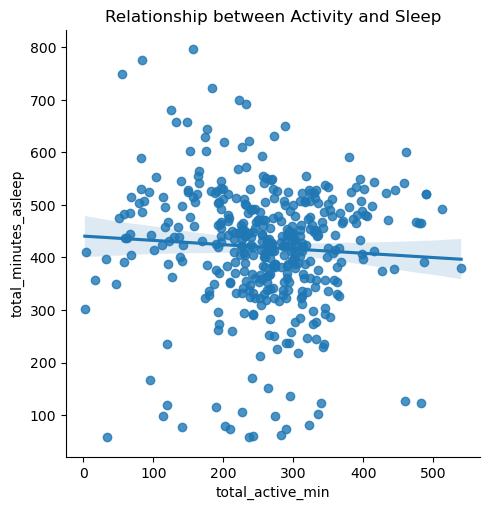

Correlation coefficient between TotalActiveTime and TotalMinutesAsleep: -0.06376059520667852
Calculated t-value: -1.2952627206903726
Critical t-value: 1.9657526798608886
Null Hypothesis is accepted. Alternate Hypothesis is rejected, i.e. there is no significant relationship between the TotalActiveTime and TotalMinutesAsleep.


In [39]:
print('TESTING 2nd HYPOTHESIS: H. = THERE IS NO SIGNIFICANT RELATIONSHIP BETWEEN HOW MUCH TIME A PERSON SPENDS BEING ACTIVE AND THE LENGTH OF SLEEP.')

# The null hypothesis for this right-tailed t-test states that there is no significant relationship 
# between how much time a person spends being active and total minutes asleep. 
# The alternative hypothesis, on the other hand, states that there is a positive relationship between the two variables, 
# meaning that as the amount of time a person spends being active increases, so does their stretch of sleep.

# Plot TotalSteps vs Calories with a linear regression line
a1 = sns.lmplot(data=df_sleep_and_activity, x='total_active_min', y='total_minutes_asleep')
plt.title('Relationship between Activity and Sleep')
plt.show()

# Calculate the correlation coefficient between TotalActiveTime and Calories
corr2 = df_sleep_and_activity['total_active_min'].corr(df_sleep_and_activity['total_minutes_asleep'])
print('Correlation coefficient between TotalActiveTime and TotalMinutesAsleep:', corr2)

# Calculate the correlation coefficient
r2, _ = stats.pearsonr(df_sleep_and_activity['total_active_min'], df_sleep_and_activity['total_minutes_asleep'])

# Calculate the degrees of freedom
n = len(df_sleep_and_activity)
df = n - 2

# Calculate the t-statistic
t2 = r2 * np.sqrt(df / (1 - r2**2))
print('Calculated t-value:', t2)

# Set the level of significance
alpha = 0.05

# The t-critical value is the cutoff between retaining or rejecting the null hypothesis. 
# Whenever the t-statistic is farther from 0 than the t-critical value, the null hypothesis is rejected; otherwise, the null hypothesis is retained.
# Determine the critical t-value
critical_t2 = stats.t.ppf(1 - alpha/2, df)
print('Critical t-value:', critical_t2)

# Reject the null hypothesis if the sample’s t value is greater than the critical value of t.
# Compare the calculated t-statistic to the critical t-value
if np.abs(t2) > critical_t2:
    print(f"Null Hypothesis is rejected. Alternate Hypothesis is accepted, i.e. there is a positive relationship between the TotalActiveTime and TotalMinutesAsleep.")
else:
    print(f"Null Hypothesis is accepted. Alternate Hypothesis is rejected, i.e. there is no significant relationship between the TotalActiveTime and TotalMinutesAsleep.")


In [45]:
df_weight.rename(columns={'Id':'id', 'Date':'date', 'WeightKg':'weight_kg', 'WeightPounds':'weight_pounds', 'Fat':'fat', 'BMI':'bmi', 
                          'IsManualReport':'is_manual_report', 'LogId':'log_id'}, inplace=True)

# create X and y variables
X = df_weight['weight_kg']
y = df_weight['bmi']

# add constant to X variable
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# print the summary statistics of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     76.68
Date:                Tue, 11 Apr 2023   Prob (F-statistic):           1.33e-12
Time:                        07:58:21   Log-Likelihood:                -143.55
No. Observations:                  67   AIC:                             291.1
Df Residuals:                      65   BIC:                             295.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.5115      1.357      9.954      0.0